# 🌎 CSE151B Spring 2025 Climate Emulation Competition

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


In [2]:
#!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet
import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import glob, os
from tensorboard.backend.event_processing import event_accumulator

### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [29]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 32,  # Larger batches for better GPU utilization 
        "num_workers": 0,  # Disable multiprocessing for Windows stability
    },
    "model": {
        "type": "improved_cnn",
        "kernel_size": 3,
        "init_dim": 80,  # Reduced from 96
        "depth":5,      # Reduced from 5
        "dropout_rate": 0.3,
    },
    "training": {
        "lr": 7e-4
    },
    "trainer": {
        "max_epochs": 50,  # Reduced for faster testing
        "accelerator": "auto",
        "devices": "auto",
        "precision": 16,
        "deterministic": True,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [4]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**.

We encourage you to build and experiment with your own models and ideas.


In [5]:
class MCDropout2d(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
        self.dropout = nn.Dropout2d(p)
        
    def forward(self, x):
        return self.dropout(x)

class ImprovedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dropout_rate=0.1, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, 
                             stride=stride, padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.mish1 = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.mish2 = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.se = SqueezeExcitation(out_channels)
        self.dropout = MCDropout2d(dropout_rate) 
        
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.mish1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out = self.dropout(out)
        out += self.skip(identity)
        return self.mish2(out)

class SqueezeExcitation(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1)
        self.relu = nn.LeakyReLU(negative_slope=0.01,inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = self.avg_pool(x)
        avg_pool = self.fc1(avg_pool)
        avg_pool = self.relu(avg_pool)
        avg_pool = self.fc2(avg_pool)
        weight = self.sigmoid(avg_pool)
        return x * weight

class ImprovedCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=128, depth=6, dropout_rate=0.4):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(init_dim),
            nn.Mish(inplace=True),
        )
        
        self.res_blocks = nn.ModuleList()
        current_dim = init_dim
        dilations = [1, 1, 2, 2, 4, 4][:depth]  
        
        for i, dilation in enumerate(dilations):
            out_dim = current_dim * 2 if i < depth - 1 else current_dim
            self.res_blocks.append(
                ImprovedResidualBlock(current_dim, out_dim, kernel_size, 
                                     dropout_rate=dropout_rate, dilation=dilation)
            )
            if i < depth - 1:
                current_dim *= 2
        
        # Add attention mechanism before final layers
        self.attention = SpatialAttention()
        
        self.dropout = nn.Dropout2d(dropout_rate)
        
        # Multi-scale output with skip connections
        self.final = nn.Sequential(
            nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 2),
            nn.LeakyReLU(negative_slope=0.01,inplace=True),
            nn.Conv2d(current_dim // 2, current_dim // 4, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 4),
            nn.LeakyReLU(negative_slope=0.01,inplace=True),
            nn.Conv2d(current_dim // 4, n_output_channels, kernel_size=1),
        )

    def forward(self, x):
        input_x = x
        x = self.initial(x)
        
        # Store intermediate activations for skip connections
        features = []
        for i, res_block in enumerate(self.res_blocks):
            x = res_block(x)
            if i % 2 == 0:  
                features.append(x)
        
        # Apply attention
        x = self.attention(x)
        x = self.dropout(x)
        
        # Final layers
        x = self.final(x)
        return x
        
        

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Average and max pooling across channel dimension
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        
        # Concatenate along the channel dimension
        pool = torch.cat([avg_pool, max_pool], dim=1)
        
        # Apply convolution and sigmoid activation
        attention = self.sigmoid(self.conv(pool))
        
        # Multiply input by attention map
        return x * attention

In [15]:
class UNet(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, init_dim=80):
        super().__init__()
        # Encoder
        self.enc1 = self._conv_block(n_input_channels, init_dim)
        self.enc2 = self._conv_block(init_dim, init_dim*2)
        self.enc3 = self._conv_block(init_dim*2, init_dim*4)
        self.enc4 = self._conv_block(init_dim*4, init_dim*8)
        
        # Decoder
        self.up4 = nn.ConvTranspose2d(init_dim*8, init_dim*4, 2, stride=2)
        self.dec4 = self._conv_block(init_dim*8, init_dim*4)
        self.up3 = nn.ConvTranspose2d(init_dim*4, init_dim*2, 2, stride=2)
        self.dec3 = self._conv_block(init_dim*4, init_dim*2)
        self.up2 = nn.ConvTranspose2d(init_dim*2, init_dim, 2, stride=2)
        self.dec2 = self._conv_block(init_dim*2, init_dim)
        
        self.final = nn.Conv2d(init_dim, n_output_channels, 1)
        self.pool = nn.MaxPool2d(2)
        nn.init.zeros_(self.final.weight)
        nn.init.zeros_(self.final.bias)

        
    def _conv_block(self, in_ch, out_ch, groups=8):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(groups, out_ch),          
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(groups, out_ch),
            nn.LeakyReLU(0.01, inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Decoder with skip connections
        d4 = self.dec4(torch.cat([self.up4(e4), e3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e2], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e1], dim=1))
        
        return self.final(d2)

class SimpleTransformer(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, patch_size=3, embed_dim=512, depth=6, num_heads=8):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = nn.Conv2d(n_input_channels, embed_dim, patch_size, stride=patch_size)
        
        # Transformer blocks
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dim_feedforward=embed_dim*4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        # Output projection
        self.output_proj = nn.ConvTranspose2d(embed_dim, n_output_channels, patch_size, stride=patch_size)
        
    def forward(self, x):
        B, C, H, W = x.shape
        
        # Create patches
        patches = self.patch_embed(x) 
        _, _, h_patches, w_patches = patches.shape
        
        # Flatten patches for transformer
        patches = patches.flatten(2).transpose(1, 2)  
        
        # Apply transformer
        patches = self.transformer(patches)
        
        # Reshape back to spatial
        patches = patches.transpose(1, 2).reshape(B, self.embed_dim, h_patches, w_patches)
        
        # Project to output
        output = self.output_proj(patches)
        
        return output

### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [7]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [8]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=360,
        batch_size=16,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=False, 
                          persistent_workers=self.num_workers > 0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=False,
                          persistent_workers=self.num_workers > 0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=False,
                          persistent_workers=self.num_workers > 0)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon
        

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [10]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4, mc_samples=30):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []
        self.mc_samples = mc_samples

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.log("train/loss", loss)  # Log loss for tracking
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    # In the ClimateEmulationModule class
    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(), 
            lr=self.hparams.learning_rate,
            weight_decay=1e-5  # Add L2 regularization
        )
        
        # Add learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=3,
            verbose=True
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

    def mc_predict(self, x, n_samples=None):
        """Perform Monte Carlo prediction with dropout enabled.
        
        Args:
            x: Input tensor
            n_samples: Number of MC samples (defaults to self.mc_samples)
            
        Returns:
            mean: Mean prediction across samples
            std: Standard deviation across samples (uncertainty)
        """
        if n_samples is None:
            n_samples = self.mc_samples
            
        # Enable dropout during inference
        self.model.train()  
        
        # Store predictions from multiple forward passes
        predictions = []
        
        # Run multiple forward passes
        for _ in range(n_samples):
            with torch.no_grad():
                pred = self.model(x)
                predictions.append(pred)
                
        # Stack along a new dimension
        predictions = torch.stack(predictions, dim=0)
        
        # Calculate mean and standard deviation
        mean_pred = torch.mean(predictions, dim=0)
        std_pred = torch.std(predictions, dim=0)
        
        # Return model to eval mode
        self.model.eval()
        
        return mean_pred, std_pred
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        
        # Use MC prediction instead of regular forward pass
        y_hat_mean, y_hat_std = self.mc_predict(x)
        
        # Save uncertainty estimation
        y_hat_np = self.normalizer.inverse_transform_output(y_hat_mean.cpu().numpy())
        y_hat_std_np = y_hat_std.cpu().numpy() * self.normalizer.std_out  # Scale uncertainty
        y_np = y.cpu().numpy()
        
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)
        
        # Store uncertainty for later analysis
        if not hasattr(self, 'test_uncertainties'):
            self.test_uncertainties = []
        self.test_uncertainties.append(y_hat_std_np)
        
        return {'pred': y_hat_np, 'target': y_np, 'uncertainty': y_hat_std_np}
    
    def on_test_epoch_end(self):
        # Original evaluation logic
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        uncertainties = np.concatenate(self.test_uncertainties, axis=0)
        
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        
        # Save uncertainties for analysis
        np.save("test_uncertainties.npy", uncertainties)
        
        
        self.test_preds.clear()
        self.test_targets.clear()
        self.test_uncertainties.clear()

In [25]:
# Improved Ensemble Module for Skewed Climate Distributions
class ImprovedEnsembleClimateModule(pl.LightningModule):
    def __init__(self, models, learning_rate=1e-4, ensemble_method='mean'):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.ensemble_method = ensemble_method
        self.save_hyperparameters(ignore=['models'])
        
        # Variable-specific loss functions for skewed distributions
        self.tas_criterion = nn.HuberLoss(delta=1.0)  
        self.pr_criterion = nn.HuberLoss(delta=0.1)   
        
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        # Get predictions from all models
        predictions = []
        for model in self.models:
            pred = model(x)
            predictions.append(pred)
        
        # Ensemble predictions
        if self.ensemble_method == 'mean':
            return torch.mean(torch.stack(predictions), dim=0)
        elif self.ensemble_method == 'weighted':
            weights = torch.softmax(torch.randn(len(predictions)), dim=0).to(x.device)
            weighted_preds = sum(w * pred for w, pred in zip(weights, predictions))
            return weighted_preds

    def compute_variable_specific_loss(self, pred, target):
        """Compute loss that accounts for different variable distributions"""
        tas_pred, pr_pred = pred[:, 0:1], pred[:, 1:2]  
        tas_target, pr_target = target[:, 0:1], target[:, 1:2]
        

        tas_loss = self.tas_criterion(tas_pred, tas_target)

        pr_loss = self.pr_criterion(pr_pred, pr_target)

        self.log("train/tas_loss", tas_loss)
        self.log("train/pr_loss", pr_loss)
        
        return 0.6 * tas_loss + 0.4 * pr_loss  

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = [m(x) for m in self.models]
        
        indiv_losses = [self.compute_variable_specific_loss(p, y) for p in preds]
        for i, l in enumerate(indiv_losses):
            self.log(f"train/model_{i}_loss", l)
            
        ensemble_pred = torch.stack(preds).mean(0)
        ens_loss = self.compute_variable_specific_loss(ensemble_pred, y)
        self.log("train/ensemble_loss", ens_loss)
        
        return torch.stack(indiv_losses + [ens_loss]).mean()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_variable_specific_loss(y_hat, y)
        self.log("val/ensemble_loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val/ensemble_loss", "interval": "epoch"}
        }

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer

    def on_validation_epoch_end(self):
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("improved_ensemble_val_preds.npy", preds)
        np.save("improved_ensemble_val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/improved_ensemble_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Improved ensemble submission saved to: {filepath}")


### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [12]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [ ]:
datamodule = ClimateDataModule(**config["data"])
model = ImprovedCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])

trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

C:\Users\ashha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [42]:
datamodule = ClimateDataModule(**config["data"])
# Create different models
improved_cnn = ImprovedCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)

unet = UNet(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"])
)

transformer = SimpleTransformer(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"])
)

# Create ensemble
ensemble_models = [improved_cnn, unet, transformer]
ensemble_module = ImprovedEnsembleClimateModule(ensemble_models, learning_rate=config["training"]["lr"])

# Train ensemble
trainer = pl.Trainer(**config["trainer"])
trainer.fit(ensemble_module, datamodule=datamodule)

C:\Users\ashha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ashha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | models        | ModuleList | 100 M  | train
1 | tas_criterion | HuberLoss  | 0      | train
2 | pr_criterion  | HuberLoss  | 0      | train
-----------------------------------------------------
100 M     Trainable params
0         Non-trainable params
100 M     Total params
402.665   Total estimated model params size (MB)
229       Modules in train mode
0         Modules in eval mode
C:\Users\ashha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connect

Epoch 0: 100%|██████████| 85/85 [06:44<00:00,  0.21it/s, v_num=54][VAL] tas: RMSE=6.4808, Time-Mean RMSE=5.3826, Time-Stddev MAE=1.7720
[VAL] pr: RMSE=3.6582, Time-Mean RMSE=2.4102, Time-Stddev MAE=2.0676
Epoch 1: 100%|██████████| 85/85 [09:15<00:00,  0.15it/s, v_num=54][VAL] tas: RMSE=6.8246, Time-Mean RMSE=5.9044, Time-Stddev MAE=1.7685
[VAL] pr: RMSE=3.4301, Time-Mean RMSE=2.0809, Time-Stddev MAE=1.9369
Epoch 2: 100%|██████████| 85/85 [09:12<00:00,  0.15it/s, v_num=54][VAL] tas: RMSE=5.7984, Time-Mean RMSE=4.9181, Time-Stddev MAE=1.8444
[VAL] pr: RMSE=3.2844, Time-Mean RMSE=1.8782, Time-Stddev MAE=1.8248
Epoch 3: 100%|██████████| 85/85 [08:37<00:00,  0.16it/s, v_num=54][VAL] tas: RMSE=5.7616, Time-Mean RMSE=5.0838, Time-Stddev MAE=1.6581
[VAL] pr: RMSE=3.0635, Time-Mean RMSE=1.5746, Time-Stddev MAE=1.7737
Epoch 4: 100%|██████████| 85/85 [08:38<00:00,  0.16it/s, v_num=54][VAL] tas: RMSE=5.2890, Time-Mean RMSE=4.6838, Time-Stddev MAE=1.4862
[VAL] pr: RMSE=2.7104, Time-Mean RMSE=1.2722

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 85/85 [06:38<00:00,  0.21it/s, v_num=54]


# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [43]:
trainer.test(ensemble_module, datamodule=datamodule)

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ashha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:24<00:00,  0.49it/s][TEST] tas: RMSE=290.8619, Time-Mean RMSE=290.8215, Time-Stddev MAE=3.4988
[TEST] pr: RMSE=3.8866, Time-Mean RMSE=3.4562, Time-Stddev MAE=1.2598
✅ Improved ensemble submission saved to: submissions/improved_ensemble_submission_20250613_141920.csv
Testing DataLoader 0: 100%|██████████| 12/12 [00:29<00:00,  0.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     3.886615037918091     │
│  test/pr/time_mean_rmse   │     3.456202268600464     │
│   test/pr/time_std_mae    │    1.2597570419311523     │
│       test/tas/rmse       │    290.86187744140625     │
│  test/tas/time_mean_rmse  │     290.821533203125      │
│   test/tas/time_std_mae   │    3.4987735748291016     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.86187744140625,
  'test/tas/time_mean_rmse': 290.821533203125,
  'test/tas/time_std_mae': 3.4987735748291016,
  'test/pr/rmse': 3.886615037918091,
  'test/pr/time_mean_rmse': 3.456202268600464,
  'test/pr/time_std_mae': 1.2597570419311523}]

In [10]:
trainer.test(lightning_module, datamodule=datamodule)

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.2775, Time-Mean RMSE=290.2333, Time-Stddev MAE=3.6966
[TEST] pr: RMSE=4.1918, Time-Mean RMSE=3.7495, Time-Stddev MAE=1.3355
✅ Submission saved to: submissions/kaggle_submission_20250517_011434.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.191776275634766     │
│  test/pr/time_mean_rmse   │     3.749460220336914     │
│   test/pr/time_std_mae    │    1.3354641199111938     │
│       test/tas/rmse       │    290.27752685546875     │
│  test/tas/time_mean_rmse  │    290.23333740234375     │
│   test/tas/time_std_mae   │    3.6965813636779785     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.27752685546875,
  'test/tas/time_mean_rmse': 290.23333740234375,
  'test/tas/time_std_mae': 3.6965813636779785,
  'test/pr/rmse': 4.191776275634766,
  'test/pr/time_mean_rmse': 3.749460220336914,
  'test/pr/time_std_mae': 1.3354641199111938}]

### Plotting Utils


In [ ]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.savefig('prediction3.png', dpi=300, bbox_inches='tight')
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


In [ ]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


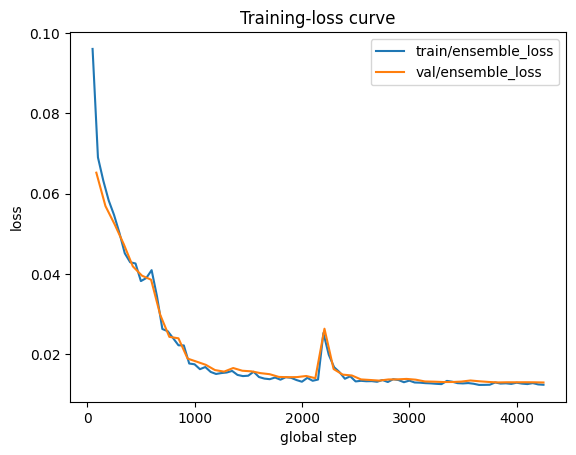

In [45]:
logdir = "lightning_logs/version_54"
ea = event_accumulator.EventAccumulator(logdir)
ea.Reload()

wanted_tags = ["train/ensemble_loss", "val/ensemble_loss"]

for tag in wanted_tags:
    if tag not in ea.Tags()["scalars"]:
        print(f"'{tag}' not found, skipping")
        continue
    events = ea.Scalars(tag)
    steps  = [e.step for e in events]
    values = [e.value for e in events]
    plt.plot(steps, values, label=tag)

plt.xlabel("global step")
plt.ylabel("loss")
plt.title("Training-loss curve")
plt.savefig('global_loss2.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

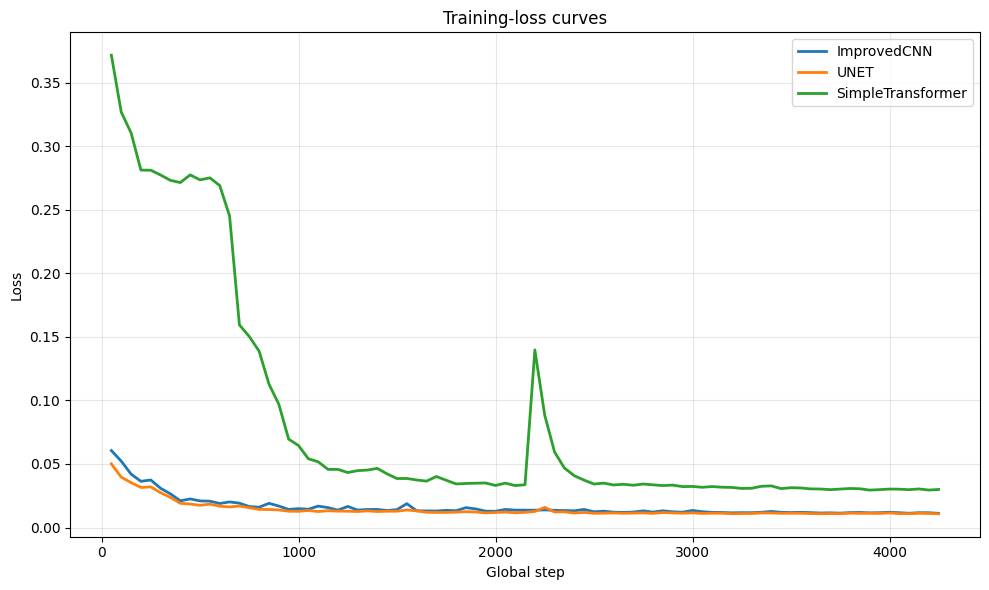

In [46]:
LOG_DIR = "lightning_logs/version_54"       


MODEL_NAMES = {
    0: "ImprovedCNN",  
    1: "UNET",  
    2: "SimpleTransformer",   
}

from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import os

# Load the event files
ea = event_accumulator.EventAccumulator(LOG_DIR)
ea.Reload()

available_tags = set(ea.Tags()["scalars"])
wanted_tags    = [f"train/model_{i}_loss" for i in range(3)]

plt.figure(figsize=(10, 6))

for i, tag in enumerate(wanted_tags):
    if tag not in available_tags:
        print(f"[warning] '{tag}' not found – skipping.")
        continue

    events = ea.Scalars(tag)
    steps  = [e.step  for e in events]
    values = [e.value for e in events]

    plt.plot(steps, values,
             label=MODEL_NAMES.get(i, f"Model {i}"),
             linewidth=2)

plt.xlabel("Global step")
plt.ylabel("Loss")
plt.title("Training-loss curves")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('training_losses2.png', dpi=150)

plt.show()

In [ ]:

ea = event_accumulator.EventAccumulator("lightning_logs/version_27",
                                        size_guidance={"scalars": 0})
ea.Reload()

print(f"\nScalar tags found in {run_dir}:\n")
for tag in ea.Tags()["scalars"]:
    print(" •", tag)


Scalar tags found in lightning_logs\version_9:

 • hp_metric
 • train/model_0_loss
 • train/model_1_loss
 • train/model_2_loss
 • train/ensemble_loss
 • epoch
 • val/ensemble_loss
 • val/tas/rmse
 • val/tas/time_mean_rmse
 • val/tas/time_std_mae
 • val/pr/rmse
 • val/pr/time_mean_rmse
 • val/pr/time_std_mae
